In [1]:
import numpy as np
import pandas as pd

In [2]:
# Parametry
n_days = 3000
np.random.seed(42)

# Czas: kolejne dni
days = np.arange(n_days)


In [3]:
# Sezonowość + trend + szum (np. temperatura w ciągu roku + cieplejszy klimat)
temperatures = (
    10 + 10 * np.sin(2 * np.pi * days / 365.25)    # sezonowość roczna
    + 0.003 * days                                 # lekki trend globalnego ocieplenia
    + np.random.normal(0, 2, n_days)               # szum
)


In [4]:
df = pd.DataFrame({
    'day': days,
    'temperature': temperatures
})

In [5]:
df.to_csv('temperatury_miesiac.csv', index=False)
print(df.head())

   day  temperature
0    0    10.993428
1    1     9.898487
2    2    11.645358
3    3    13.570903
4    4    10.231247


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Wczytaj dane
df = pd.read_csv('temperatury_miesiac.csv')

X = df[['day']].values
y = df['temperature'].values

In [8]:
# Skalowanie cechy (ważne dla sieci!)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [9]:
# Podział na train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, shuffle=False)

In [10]:
# Model: pojedyncza warstwa – klasyczna regresja liniowa
model_linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,))
])
model_linear.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
history_linear = model_linear.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))

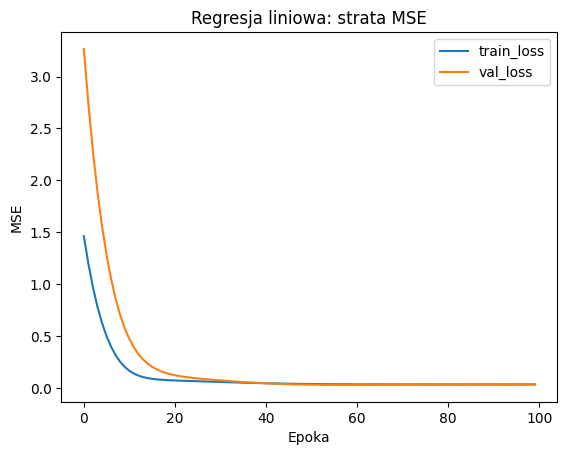

In [12]:
# Wizualizacja przebiegu uczenia
plt.plot(history_linear.history['loss'], label='train_loss')
plt.plot(history_linear.history['val_loss'], label='val_loss')
plt.title("Regresja liniowa: strata MSE")
plt.xlabel("Epoka")
plt.ylabel("MSE")
plt.legend()
plt.show()


In [13]:
# Głęboka sieć: 3 warstwy + nieliniowość
model_deep = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])
model_deep.compile(optimizer='adam', loss='mse')

In [14]:
history_deep = model_deep.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))

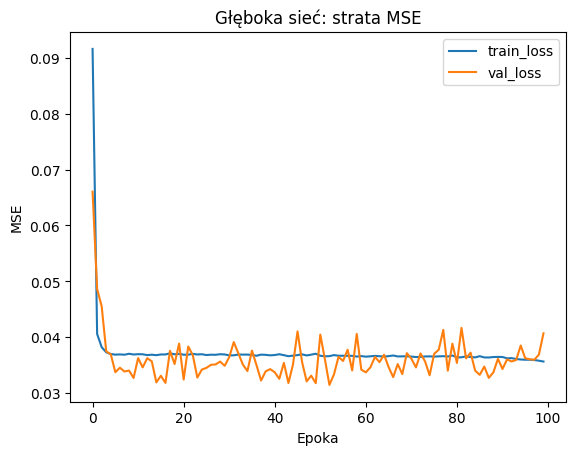

In [15]:
plt.plot(history_deep.history['loss'], label='train_loss')
plt.plot(history_deep.history['val_loss'], label='val_loss')
plt.title("Głęboka sieć: strata MSE")
plt.xlabel("Epoka")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [16]:
# Prognoza na 30 dni po ostatnim dniu
future_days = np.arange(n_days, n_days + 30).reshape(-1, 1)
future_days_scaled = scaler_X.transform(future_days)

# Prognozy
pred_linear = model_linear.predict(future_days_scaled)
pred_deep = model_deep.predict(future_days_scaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [17]:
# Odwracamy skalowanie
pred_linear_real = scaler_y.inverse_transform(pred_linear)
pred_deep_real = scaler_y.inverse_transform(pred_deep)

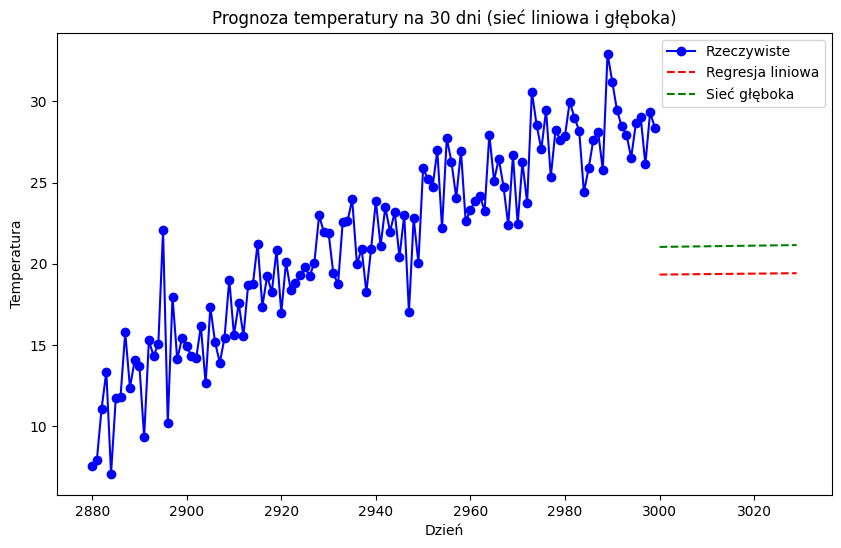

In [19]:
# Wizualizacja – ostatnie 60 dni + predykcja na 30 dni
plt.figure(figsize=(10,6))
plt.plot(df['day'].iloc[-120:], df['temperature'].iloc[-120:], 'bo-', label='Rzeczywiste')
plt.plot(np.arange(n_days, n_days + 30), pred_linear_real, 'r--', label='Regresja liniowa')
plt.plot(np.arange(n_days, n_days + 30), pred_deep_real, 'g--', label='Sieć głęboka')
plt.xlabel('Dzień')
plt.ylabel('Temperatura')
plt.title('Prognoza temperatury na 30 dni (sieć liniowa i głęboka)')
plt.legend()
plt.show()